In [520]:
import pandas as pd
import arff
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans


In [462]:
file_path = 'Data/autism+screening+adult/Autism-Adult-Data.arff'
data = arff.load(open(file_path, 'r'))
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])

In [463]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,United States,no,6.0,18 and more,Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,None,no,no,Egypt,no,2.0,18 and more,None,NO


## Fixing missing values and adjusting dtype

In [464]:
print(df.isnull().sum())

A1_Score            0
A2_Score            0
A3_Score            0
A4_Score            0
A5_Score            0
A6_Score            0
A7_Score            0
A8_Score            0
A9_Score            0
A10_Score           0
age                 2
gender              0
ethnicity          95
jundice             0
austim              0
contry_of_res       0
used_app_before     0
result              0
age_desc            0
relation           95
Class/ASD           0
dtype: int64


In [465]:
# Replacing the missing age values with the median
df['age'].fillna(df['age'].median(), inplace=True)

# For the ethnicities missing putting 'unknown' rather than the mode 
df['ethnicity'].fillna('Unknown', inplace=True)

# Doing the same for Relation
df['relation'].fillna('Unknown', inplace=True)

/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_16736/1699320158.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/var/folders/m9/nwvp3yqj5f76trygypnkypv80000gp/T/ipykernel_16736/1699320158.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [466]:
label_encoders = {}
categorical_columns = ['gender', 'ethnicity', 'jundice', 'austim', 'used_app_before', 'relation', 'Class/ASD']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert to numerical representation
    label_encoders[col] = le  # Store the encoder for inverse transformations if needed

scaler = StandardScaler()
df[['age', 'result']] = scaler.fit_transform(df[['age', 'result']])

for col in [f'A{i}_Score' for i in range(1, 11)]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert columns to categorical types where appropriate
categorical_columns = ['gender', 'ethnicity', 'jundice', 'austim', 
                       'contry_of_res', 'used_app_before', 'relation', 'Class/ASD']
for col in categorical_columns:
    df[col] = df[col].astype('category')

df.drop('age_desc', axis=1, inplace=True)

In [467]:
print(df.dtypes)

A1_Score              int64
A2_Score              int64
A3_Score              int64
A4_Score              int64
A5_Score              int64
A6_Score              int64
A7_Score              int64
A8_Score              int64
A9_Score              int64
A10_Score             int64
age                 float64
gender             category
ethnicity          category
jundice            category
austim             category
contry_of_res      category
used_app_before    category
result              float64
relation           category
Class/ASD          category
dtype: object


In [468]:
print(df.isnull().sum()) 

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
relation           0
Class/ASD          0
dtype: int64


## Training

In [469]:
X = df.drop('Class/ASD', axis=1)  
y = df['Class/ASD']  

In [470]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [471]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (563, 19)
X_test shape: (141, 19)
y_train shape: (563,)
y_test shape: (141,)


In [472]:
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest

In [473]:
df_encoded = pd.get_dummies(df, columns=['gender', 'ethnicity', 'contry_of_res', 'relation'], drop_first=True)

X = df_encoded.drop('Class/ASD', axis=1)
y = df_encoded['Class/ASD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [474]:
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Logistic Regression Accuracy: 1.0
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        36

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

Logistic Regression Confusion Matrix:
 [[105   0]
 [  0  36]]
Random Forest Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        36

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

Random Forest Confusion Matrix:
 [[105   0]
 [  0  36]]


## Cross-Validation

In [475]:
from sklearn.model_selection import cross_val_score

In [476]:
# For Logistic Regression
log_reg_scores = cross_val_score(log_reg, X, y, cv=5)  # 5-fold cross-validation
print("Logistic Regression CV Scores:", log_reg_scores)
print("Logistic Regression Average CV Score:", log_reg_scores.mean())

# For Random Forest
rf_scores = cross_val_score(rf, X, y, cv=5)
print("Random Forest CV Scores:", rf_scores)
print("Random Forest Average CV Score:", rf_scores.mean())

Logistic Regression CV Scores: [1.         1.         1.         1.         0.99285714]
Logistic Regression Average CV Score: 0.9985714285714286
Random Forest CV Scores: [1. 1. 1. 1. 1.]
Random Forest Average CV Score: 1.0


## Cross-Validation Results - 
#### Logistic Regression:
- CV Scores: [1.0, 1.0, 1.0, 1.0, 0.99285714]
- Average CV Score: 0.99857 (approximately 99.86%)
---------------------------------------------------
#### Random Forest:
- CV Scores: [1.0, 1.0, 1.0, 1.0, 1.0]
- Average CV Score: 1.0 (100%)

## Review Data Quality 

In [477]:
print(y.value_counts())

Class/ASD
0    515
1    189
Name: count, dtype: int64


In [478]:
print(df.head())
print(df.info())

   A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0         1         1         1         1         0         0         1   
1         1         1         0         1         0         0         0   
2         1         1         0         1         1         0         1   
3         1         1         0         1         0         0         1   
4         1         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score       age gender ethnicity jundice austim  \
0         1         0          0 -0.224025      0        10       0      0   
1         1         0          1 -0.345437      1         3       0      1   
2         1         1          1 -0.163319      1         3       1      1   
3         1         0          1  0.322327      0        10       0      1   
4         1         0          0  0.625856      0         9       0      0   

   contry_of_res used_app_before    result relation Class/ASD  
0  United States

In [479]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [480]:
X = df_encoded.drop('Class/ASD_1', axis=1)
y = df_encoded['Class/ASD_1']

In [481]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [482]:
print(X.isnull().sum())

A1_Score      0
A2_Score      0
A3_Score      0
A4_Score      0
A5_Score      0
             ..
relation_1    0
relation_2    0
relation_3    0
relation_4    0
relation_5    0
Length: 98, dtype: int64


In [483]:
imputer = SimpleImputer(strategy='mean')
X['age'] = imputer.fit_transform(X[['age']])

In [484]:
# Display rows with NaN values
print(X[X.isnull().any(axis=1)])

Empty DataFrame
Columns: [A1_Score, A2_Score, A3_Score, A4_Score, A5_Score, A6_Score, A7_Score, A8_Score, A9_Score, A10_Score, age, result, gender_1, ethnicity_1, ethnicity_2, ethnicity_3, ethnicity_4, ethnicity_5, ethnicity_6, ethnicity_7, ethnicity_8, ethnicity_9, ethnicity_10, ethnicity_11, jundice_1, austim_1, contry_of_res_AmericanSamoa, contry_of_res_Angola, contry_of_res_Argentina, contry_of_res_Armenia, contry_of_res_Aruba, contry_of_res_Australia, contry_of_res_Austria, contry_of_res_Azerbaijan, contry_of_res_Bahamas, contry_of_res_Bangladesh, contry_of_res_Belgium, contry_of_res_Bolivia, contry_of_res_Brazil, contry_of_res_Burundi, contry_of_res_Canada, contry_of_res_Chile, contry_of_res_China, contry_of_res_Costa Rica, contry_of_res_Cyprus, contry_of_res_Czech Republic, contry_of_res_Ecuador, contry_of_res_Egypt, contry_of_res_Ethiopia, contry_of_res_Finland, contry_of_res_France, contry_of_res_Germany, contry_of_res_Hong Kong, contry_of_res_Iceland, contry_of_res_India, con

In [485]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   A1_Score         704 non-null    int64   
 1   A2_Score         704 non-null    int64   
 2   A3_Score         704 non-null    int64   
 3   A4_Score         704 non-null    int64   
 4   A5_Score         704 non-null    int64   
 5   A6_Score         704 non-null    int64   
 6   A7_Score         704 non-null    int64   
 7   A8_Score         704 non-null    int64   
 8   A9_Score         704 non-null    int64   
 9   A10_Score        704 non-null    int64   
 10  age              704 non-null    float64 
 11  gender           704 non-null    category
 12  ethnicity        704 non-null    category
 13  jundice          704 non-null    category
 14  austim           704 non-null    category
 15  contry_of_res    704 non-null    category
 16  used_app_before  704 non-null    category
 1

Since all columns show 704 non-null values, your dataset is complete, which is good for analysis and modeling.

## Initiate and Train Models

In [486]:
log_reg = LogisticRegression()
rf = RandomForestClassifier()

# Train models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [487]:
# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)

## Evaluation

In [488]:
# Logistic Regression Evaluation
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))

# Random Forest Evaluation
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Logistic Regression Accuracy: 1.0
Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        97
        True       1.00      1.00      1.00       109

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206

Logistic Regression Confusion Matrix:
[[ 97   0]
 [  0 109]]
Random Forest Accuracy: 1.0
Random Forest Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        97
        True       1.00      1.00      1.00       109

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206

Random Forest Confusion Matrix:
[[ 97   0]
 [  0 109]]


### What You Can Gather:
- Perfect scores indicate that both models fit the data extremely well, which is usually a **red flag** when dealing with real-world data. 

#### This could mean:
- Overfitting: Your models might have memorized the training data, especially if the data is small or if there are patterns that are too easy to detect.
- Data leakage: There might be information in the data that the models are exploiting to make perfect predictions, such as a feature strongly correlated with the target.

In [489]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances)

result                      0.309195
A9_Score                    0.118287
A5_Score                    0.102820
A6_Score                    0.064662
A4_Score                    0.063012
                              ...   
contry_of_res_Costa Rica    0.000000
contry_of_res_Japan         0.000000
contry_of_res_Serbia        0.000000
contry_of_res_Tonga         0.000000
contry_of_res_Turkey        0.000000
Length: 98, dtype: float64


#### Feature Importance Plot – 
Visualize the most important features driving the model’s predictions.

The **major** issue with predicting if someone has ASD or not based off of demographics is that you will get a bias image of what someone with ASD looks like. Usually being a white, 9-year-old, boy, as this is where most of the studies and focus has been. Completely leaving out women, younger and older people, people of color, and under diagnosing a massive portion of the population. 

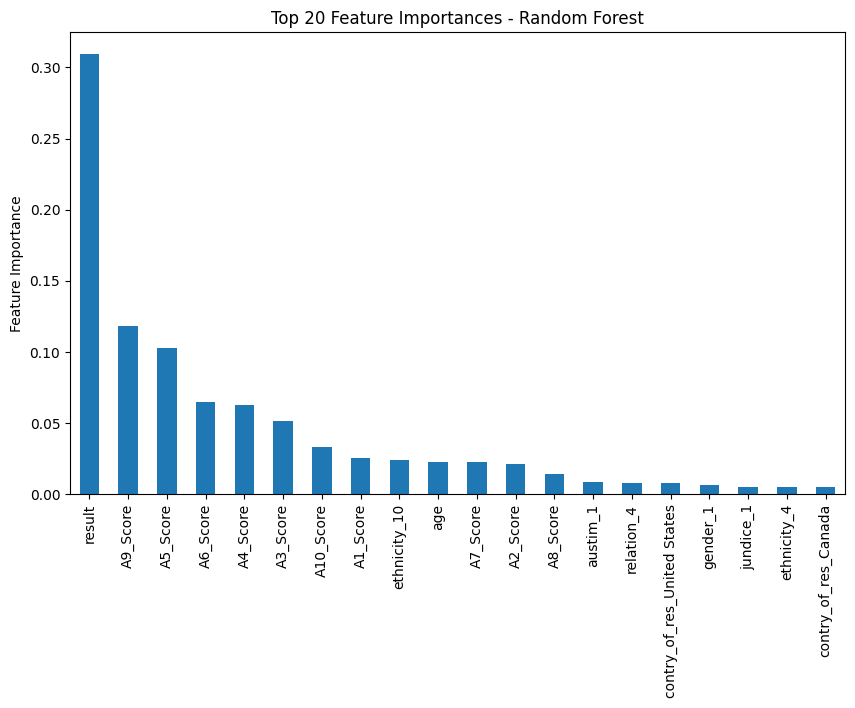

In [490]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importances[:20].plot(kind='bar')
plt.title("Top 20 Feature Importances - Random Forest")
plt.ylabel("Feature Importance")
plt.show()

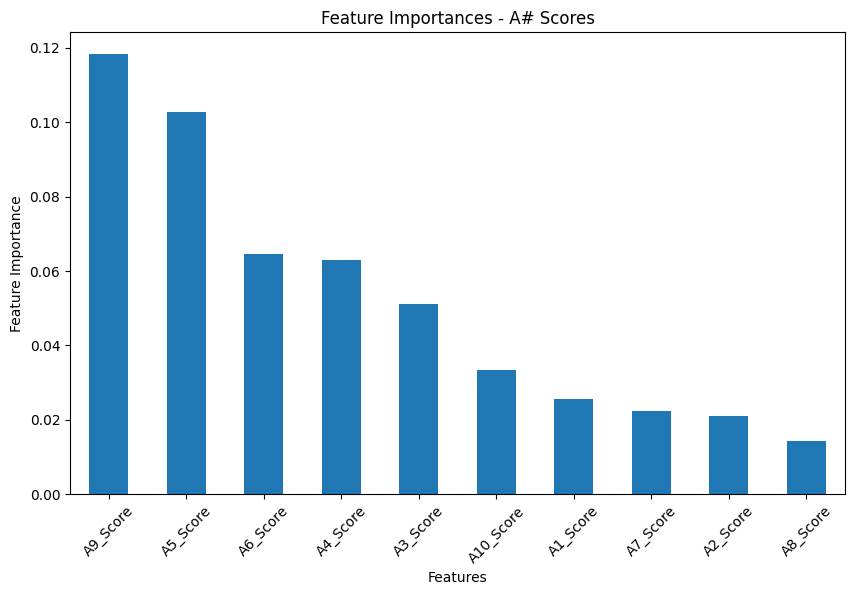

In [491]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# List of A#_Scores to include
score_features = [f'A{i}_Score' for i in range(1, 11)]  # Adjust the range if you have more or fewer scores

# Filter the feature importances to include only A#_Scores
filtered_feature_importances = feature_importances[feature_importances.index.isin(score_features)]

# Plot the feature importances for A#_Scores
plt.figure(figsize=(10, 6))
filtered_feature_importances.plot(kind='bar')
plt.title("Feature Importances - A# Scores")
plt.ylabel("Feature Importance")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.show()

## Retraining

In [517]:
score_features = [f'A{i}_Score' for i in range(1, 11)]  # Adjust based on your actual score features

X = df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']]
y = df['Class/ASD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [518]:
# Initialize models
log_reg = LogisticRegression()
rf = RandomForestClassifier()

# Train models
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [519]:
# Predictions
log_reg_pred = log_reg.predict(X_test)
rf_pred = rf.predict(X_test)

# Classification reports
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_pred))

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        36

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.97      1.00      0.99        36

    accuracy                           0.99       141
   macro avg       0.99      1.00      0.99       141
weighted avg       0.99      0.99      0.99       141



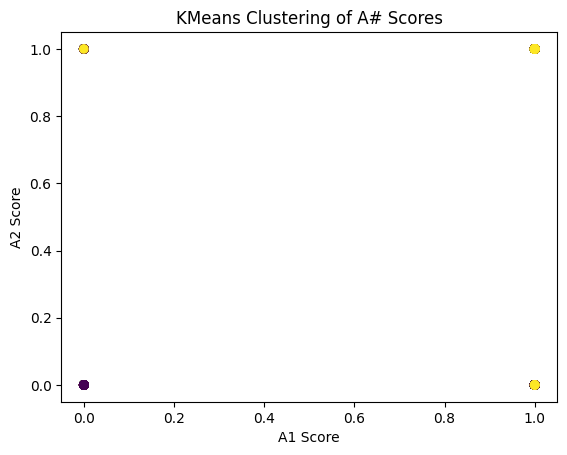

In [521]:
k = 2

# Initialize KMeans
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit model
kmeans.fit(X)

# Predict cluster labels
clusters = kmeans.predict(X)

# Add cluster labels to the original data for analysis
df['Cluster'] = clusters

# Visualize clusters (2D visualization for demonstration)
plt.scatter(df['A1_Score'], df['A2_Score'], c=df['Cluster'], cmap='viridis')
plt.title("KMeans Clustering of A# Scores")
plt.xlabel("A1 Score")
plt.ylabel("A2 Score")
plt.show()